In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from ROOT import TChain
import numpy as np
import pandas as pd

# Read data in and create event-wise row dataframe
names=['sparse3d_sed','sparse3d_pcluster','sparse3d_masked_true','particle_pcluster']
fname='./integrity_check/eshower_highstat_random.root'
ch_true=TChain("%s_tree" % names[0])
ch_reco=TChain("%s_tree" % names[1])
ch_mask=TChain("%s_tree" % names[2])
ch_part=TChain("%s_tree" % names[3])
for ch in [ch_true,ch_reco,ch_mask,ch_part]: ch.AddFile(fname)
print("Found %d entries" % ch_true.GetEntries())
data = np.zeros(shape=(ch_true.GetEntries(),7),dtype=np.float32)
for entry in range(ch_true.GetEntries()):
    for ch in [ch_true,ch_reco,ch_mask,ch_part]: ch.GetEntry(entry)
    br_true = getattr(ch_true,'%s_branch' % names[0])
    br_reco = getattr(ch_reco,'%s_branch' % names[1])
    br_mask = getattr(ch_mask,'%s_branch' % names[2])
    br_part = getattr(ch_part,'%s_branch' % names[3])
    #energy = br_true.sum()
    for p in br_part.as_vector():
        if not p.track_id() == 1: continue
        energy = p.energy_init() - 0.511
    data[entry] = (energy,br_true.size(),br_reco.size(),br_mask.size(),
                   br_true.sum(),br_reco.sum(),br_mask.sum())

df=pd.DataFrame(data=data,columns=['energy','nvox_true','nvox_reco','nvox_mask',
                                   'sum_true','sum_reco','sum_mask'])

# Do binned energy analysis
emin=50
dat=[]
for i in range(15):
    vmin=emin+i*20
    vmax=emin+(i+1)*20
    sdf = df.query('energy > %d and energy < %d' % (vmin,vmax))
    true_mean  = sdf.energy.mean()
    # for true
    bias_corr  = true_mean / sdf.nvox_true.mean()
    true_res   = ((sdf.nvox_true * bias_corr - true_mean) / true_mean).std()
    # for mask
    bias_corr  = true_mean / sdf.nvox_mask.mean()
    mask_res   = ((sdf.nvox_mask * bias_corr - true_mean) / true_mean).std()
    # for reco
    bias_corr  = true_mean / sdf.nvox_reco.mean()
    reco_res   = ((sdf.nvox_reco * bias_corr - true_mean) / true_mean).std()
    dat.append([vmin+(vmax-vmin)/2.,
                sdf.nvox_true.mean(),sdf.nvox_true.std(),true_res, 
                sdf.nvox_mask.mean(),sdf.nvox_mask.std(),mask_res, 
                sdf.nvox_reco.mean(),sdf.nvox_reco.std(),reco_res, 
               ])
edf = pd.DataFrame(data=np.array(dat),
                   columns=['energy',
                            'mean_true','std_true','res_true',
                            'mean_mask','std_mask','res_mask',
                            'mean_reco','std_reco','res_reco'
                           ]
                  )

Found 2000 entries


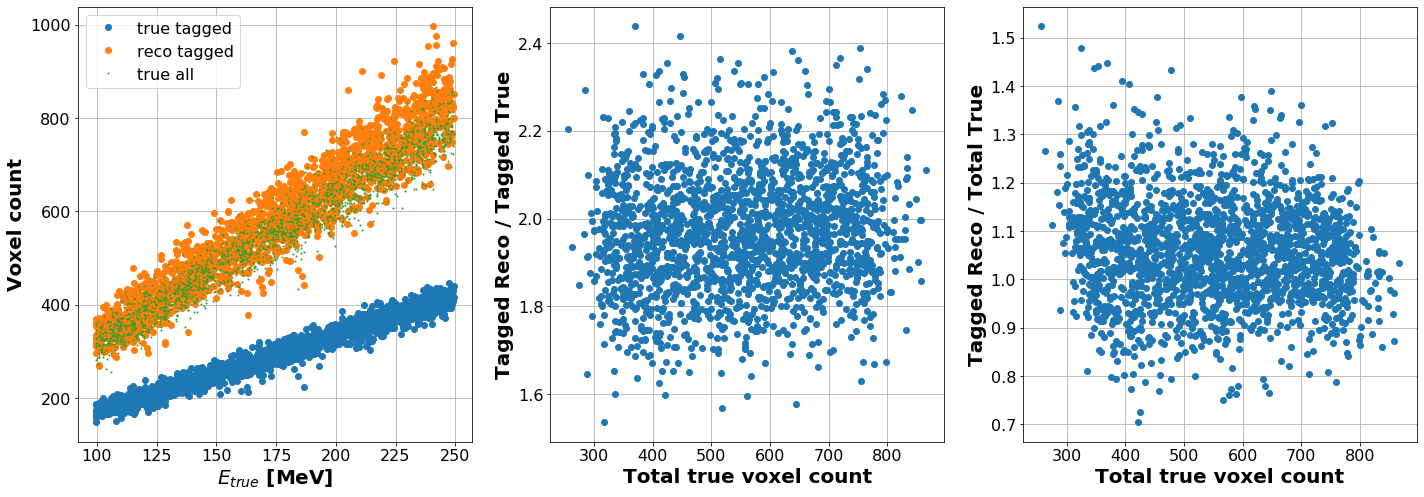

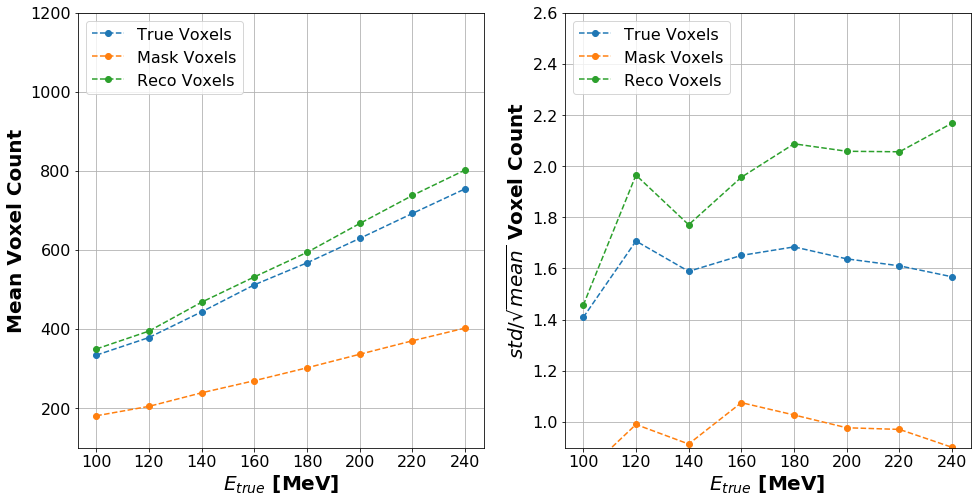

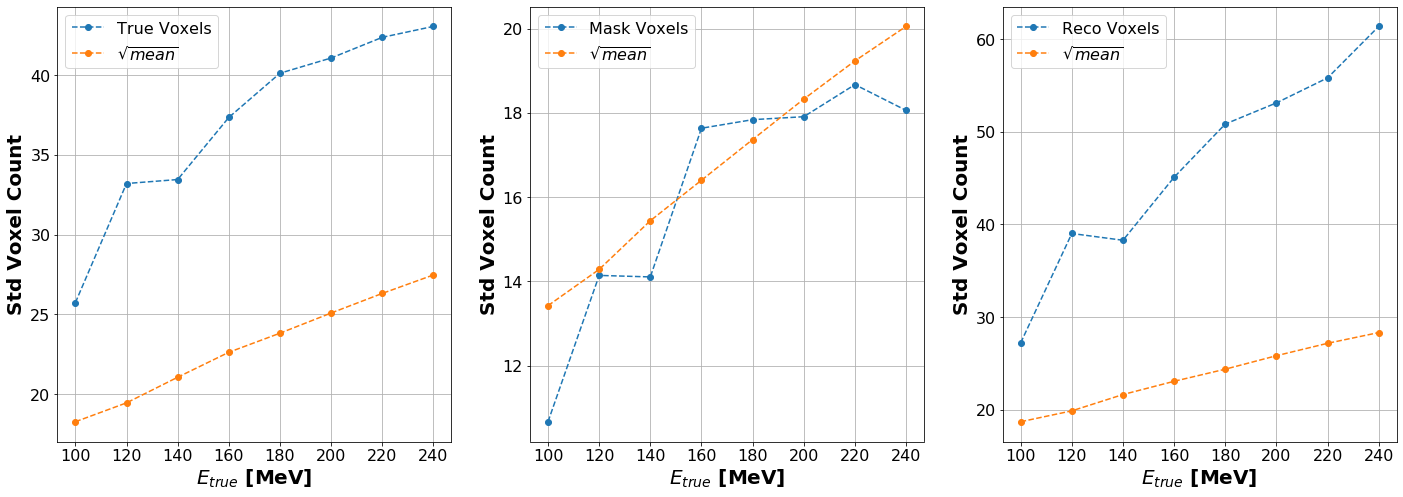

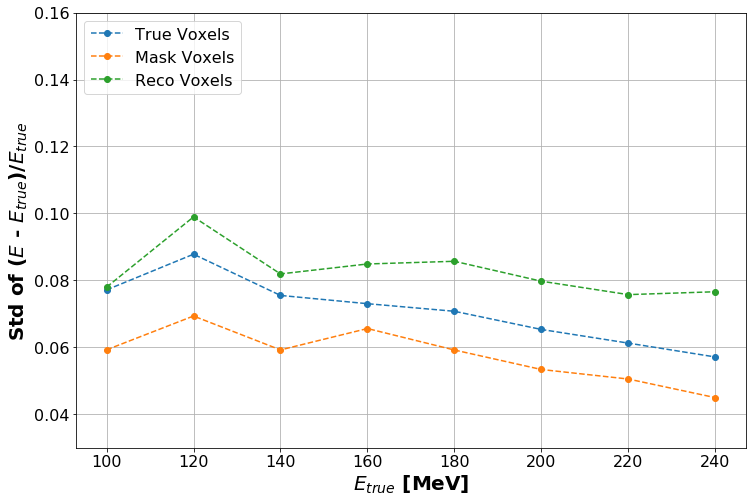

In [6]:
fig,axes=plt.subplots(1,3,figsize=(24,8),facecolor='w')
axes[0].plot(df.energy,df.nvox_mask,label='true tagged',marker='o',linestyle='')
axes[0].plot(df.energy,df.nvox_reco,label='reco tagged',marker='o',linestyle='')
axes[0].plot(df.energy,df.nvox_true,label='true all',marker='o',linestyle='',markersize=1)
axes[0].set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
axes[0].set_ylabel('Voxel count',fontsize=20,fontweight='bold')
leg=axes[0].legend(fontsize=16,loc=2)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
axes[1].plot(df.nvox_true,df.nvox_reco/df.nvox_mask,marker='o',linestyle='')
axes[1].set_xlabel('Total true voxel count',fontsize=20,fontweight='bold')
axes[1].set_ylabel('Tagged Reco / Tagged True',fontsize=20,fontweight='bold')
axes[2].plot(df.nvox_true,df.nvox_reco/df.nvox_true,marker='o',linestyle='')
axes[2].set_xlabel('Total true voxel count',fontsize=20,fontweight='bold')
axes[2].set_ylabel('Tagged Reco / Total True',fontsize=20,fontweight='bold')
for ax in axes: 
    ax.grid(True,which='both')
    ax.tick_params('both',labelsize=16)
plt.show()

fig,axes=plt.subplots(1,2,figsize=(16,8),facecolor='w')
axes[0].plot(edf.energy,edf.mean_true,label='True Voxels',marker='o',linestyle='--')
axes[0].plot(edf.energy,edf.mean_mask,label='Mask Voxels',marker='o',linestyle='--')
axes[0].plot(edf.energy,edf.mean_reco,label='Reco Voxels',marker='o',linestyle='--')
axes[0].set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
axes[0].set_ylabel('Mean Voxel Count',fontsize=20,fontweight='bold')
axes[0].set_ylim(100,1200)
axes[1].plot(edf.energy,edf.std_true/np.sqrt(edf.mean_true),label='True Voxels',marker='o',linestyle='--')
axes[1].plot(edf.energy,edf.std_mask/np.sqrt(edf.mean_mask),label='Mask Voxels',marker='o',linestyle='--')
axes[1].plot(edf.energy,edf.std_reco/np.sqrt(edf.mean_reco),label='Reco Voxels',marker='o',linestyle='--')
axes[1].set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
axes[1].set_ylabel('$std/\sqrt{mean}$ Voxel Count',fontsize=20,fontweight='bold')
axes[1].set_ylim(0.9,2.6)
for ax in axes.reshape([-1]):
    ax.grid(True,which='both')
    ax.tick_params('both',labelsize=16)
    leg=ax.legend(fontsize=16,loc=2)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
plt.show()

fig,axes=plt.subplots(1,3,figsize=(24,8),facecolor='w')
axes[0].plot(edf.energy,edf.std_true,label='True Voxels',marker='o',linestyle='--')
axes[0].plot(edf.energy,np.sqrt(edf.mean_true),label='$\sqrt{mean}$',marker='o',linestyle='--')
axes[0].set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
axes[0].set_ylabel('Std Voxel Count',fontsize=20,fontweight='bold')
axes[1].plot(edf.energy,edf.std_mask,label='Mask Voxels',marker='o',linestyle='--')
axes[1].plot(edf.energy,np.sqrt(edf.mean_mask),label='$\sqrt{mean}$',marker='o',linestyle='--')
axes[1].set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
axes[1].set_ylabel('Std Voxel Count',fontsize=20,fontweight='bold')
axes[2].plot(edf.energy,edf.std_reco,label='Reco Voxels',marker='o',linestyle='--')
axes[2].plot(edf.energy,np.sqrt(edf.mean_reco),label='$\sqrt{mean}$',marker='o',linestyle='--')
axes[2].set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
axes[2].set_ylabel('Std Voxel Count',fontsize=20,fontweight='bold')
for ax in axes.reshape([-1]):
    ax.grid(True,which='both')
    ax.tick_params('both',labelsize=16)
    leg=ax.legend(fontsize=16,loc=2)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
plt.show()

fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
ax.plot(edf.energy,edf.res_true,label='True Voxels',marker='o',linestyle='--')
ax.plot(edf.energy,edf.res_mask,label='Mask Voxels',marker='o',linestyle='--')
ax.plot(edf.energy,edf.res_reco,label='Reco Voxels',marker='o',linestyle='--')
ax.set_ylim(0.03,0.16)
ax.set_xlabel('$E_{true}$ [MeV]',fontsize=20,fontweight='bold')
ax.set_ylabel('Std of ($E$ - $E_{true}$)/$E_{true}$',fontsize=20,fontweight='bold')
ax.grid(True,which='both')
ax.tick_params('both',labelsize=16)
leg=ax.legend(fontsize=16,loc=2)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()